# 巴菲特選股策略範例 ( 作業版 )

本策略分成以下兩部分：
- 運用 TejToolAPI 抓取巴菲特選股策略所需之財務面日資料，將資料進行清洗與篩選後，找出符合選股策略的標的。
- 運用 TQuant Lab 將標的進行買進持有一年 (2023-01-01 至 2023-12-31)，觀察其風險與報酬表現。

巴菲特 4 大選股條件如下：
1. 最近年度股東權益報酬率 ＞ 平均值 (市場及產業)
2. 2 年平均股東權益報酬率 ＞ 17 %
3. 最近年度毛利率 ＞ 產業平均值
4. ( 最近年度自由現金流量 / 前年度自由現金流量 ) - 1 > 1.5

## 設定基本套件與環境

``` python
os.environ['TEJAPI_KEY'] = tej_key    ==> 個人 api key 以驗證身分。
os.environ['TEJAPI_BASE'] = api_base  ==> 導航至 tej api 網域。
```

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# tej_key
tej_key = 'G3bD8xWb79qNk4gE5FHBD3NDvvsIsV'
api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_KEY'] = tej_key 
os.environ['TEJAPI_BASE'] = api_base

## 使用 `get_universe()` 函式取得股票池
`get_universe()` 函數可以幫助我們抓取特定的股票池（市場、板塊、證券種類、產業）。  
由於巴菲特的投資法則希望標的上市時間大於一定的年限，因此我們選取 2021 年初即已上市的公司。  
另外，因為 ROE 可以藉由舉債來提升，因此我們排除金融產業這類高槓桿的產業。

p.s. 關於 `get_universe()` 的說明，可參考 TQuant Lab github：[get_universe 說明](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/get_universe%E8%AA%AA%E6%98%8E.ipynb)

In [3]:
from zipline.sources.TEJ_Api_Data import get_universe

pool = get_universe(start = '2021-01-04', 
                    end = '2021-01-04',  # 選取 2021 年年初已上市的股票
                    mkt_bd_e = 'TSE',  # 填入：上市一般版股票
                    stktp_e = 'Common Stock',  # 填入：普通股股票 
                    main_ind_e = 'General Industry') # general industry 篩掉金融產業
pool

Currently used TEJ API key call quota 1/1000 (0.1%)
Currently used TEJ API key data quota 831/10000000 (0.01%)


['1101',
 '1102',
 '1103',
 '1104',
 '1108',
 '1109',
 '1110',
 '1201',
 '1203',
 '1210',
 '1213',
 '1215',
 '1216',
 '1217',
 '1218',
 '1219',
 '1220',
 '1225',
 '1227',
 '1229',
 '1231',
 '1232',
 '1233',
 '1234',
 '1235',
 '1236',
 '1301',
 '1303',
 '1304',
 '1305',
 '1307',
 '1308',
 '1309',
 '1310',
 '1312',
 '1313',
 '1314',
 '1315',
 '1316',
 '1319',
 '1321',
 '1323',
 '1324',
 '1325',
 '1326',
 '1339',
 '1342',
 '1402',
 '1409',
 '1410',
 '1413',
 '1414',
 '1416',
 '1417',
 '1418',
 '1419',
 '1423',
 '1432',
 '1434',
 '1435',
 '1436',
 '1437',
 '1438',
 '1439',
 '1440',
 '1441',
 '1442',
 '1443',
 '1444',
 '1445',
 '1446',
 '1447',
 '1449',
 '1451',
 '1452',
 '1453',
 '1454',
 '1455',
 '1456',
 '1457',
 '1459',
 '1460',
 '1463',
 '1464',
 '1465',
 '1466',
 '1467',
 '1468',
 '1470',
 '1471',
 '1472',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1503',
 '1504',
 '1506',
 '1507',
 '1512',
 '1513',
 '1514',
 '1515',
 '1516',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1525',
 

In [4]:
len(pool)  # 836

836

## 利用 TejToolAPI 抓取所需的財務資料
根據上述選股條件，我們需要的財務科目有以下 5 項：
1. 主產業別_中文
2. 常續ROE
3. 營業毛利率
4. 營運產生現金流量
5. 投資產生現金流量

註： 
- TejToolAPI 的詳細使用方法可參考 TQuant Lab github：[TejToolAPI 說明](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Data%20Preprocess%20-%20tejtoolapi.ipynb)
- TejToolAPI 提供之資料集可參考 TQuant Lab 官網：[TQuant Lab 資料集](https://tquant.tejwin.com/%e8%b3%87%e6%96%99%e9%9b%86/)

In [5]:
import TejToolAPI

start_time = pd.Timestamp('2021-01-05')
end_time = pd.Timestamp('2022-12-30')  # 將時間字串轉換成時間格式

data = TejToolAPI.get_history_data(start = start_time,
                                   end = end_time,
                                   ticker = pool,  # 填入：正確參數名稱 & 股票池列表 ( list )
                                   fin_type = 'A', # 為累計資料，舉例來說，Q3累計：1月～9月的資料。
                                   columns = ['主產業別_中文', '常續ROE', '營業毛利率', '營運產生現金流量', '投資產生現金流量'],
                                   transfer_to_chinese = True)

data['自由現金流量'] = data['營運產生現金流量_A'] + data['投資產生現金流量_A']  # 計算自由現金流量 = 營運產生現金流量 + (-)投資產生現金流量
data.drop(columns = ['營運產生現金流量_A', '投資產生現金流量_A'], inplace = True)  # 移除欄位

data

Currently used TEJ API key call quota 57/1000 (5.7%)
Currently used TEJ API key data quota 588484/10000000 (5.88%)


,股票代碼,日期,主產業別_中文,營業毛利率_A,常續ROE_A,自由現金流量
0,1101,2021-01-05,M1100 水泥工業,NaN,NaN,NaN
1,1102,2021-01-05,M1100 水泥工業,NaN,NaN,NaN
2,1103,2021-01-05,M1100 水泥工業,NaN,NaN,NaN
3,1104,2021-01-05,M1100 水泥工業,NaN,NaN,NaN
4,1108,2021-01-05,M1100 水泥工業,NaN,NaN,NaN
...,...,...,...,...,...,...
405795,9944,2022-12-30,M9900 其他,26.99,1.94,597193.0
405796,9945,2022-12-30,M9900 其他,22.23,22.26,-791032.0
405797,9946,2022-12-30,M2500 建材營造,16.70,1.51,554326.0
405798,9955,2022-12-30,M9900 其他,0.01,-5.44,-28051.0


## 選股條件 1：最近年度股東權益報酬率＞平均值(市場及產業)

In [6]:
# 取出最近年度(2022-12-30)的資料
data_last_1Y = data[data['日期'] == '2022-12-30'].reset_index(drop = True)  

# 取出股票基本資料與 ROE 資料方便觀察
ROE_1Y_data = data_last_1Y[['股票代碼', '日期', '主產業別_中文', '常續ROE_A']]

ROE_1Y_data

,股票代碼,日期,主產業別_中文,常續ROE_A
0,1101,2022-12-30,M1100 水泥工業,-0.07
1,1102,2022-12-30,M1100 水泥工業,5.60
2,1103,2022-12-30,M1100 水泥工業,-1.32
3,1104,2022-12-30,M1100 水泥工業,5.10
4,1108,2022-12-30,M1100 水泥工業,6.30
...,...,...,...,...
819,9944,2022-12-30,M9900 其他,1.94
820,9945,2022-12-30,M9900 其他,22.26
821,9946,2022-12-30,M2500 建材營造,1.51
822,9955,2022-12-30,M9900 其他,-5.44


In [7]:
# 依不同產業分類，計算出產業平均 ROE
# 填入：欲進行分類的財務科目
industry_ROE_ave = ROE_1Y_data.groupby('主產業別_中文')['常續ROE_A'].transform('mean') 

# 加入 '產業平均ROE' 欄位
ROE_1Y_data['產業平均ROE'] = industry_ROE_ave
 
ROE_1Y_data

,股票代碼,日期,主產業別_中文,常續ROE_A,產業平均ROE
0,1101,2022-12-30,M1100 水泥工業,-0.07,2.777143
1,1102,2022-12-30,M1100 水泥工業,5.60,2.777143
2,1103,2022-12-30,M1100 水泥工業,-1.32,2.777143
3,1104,2022-12-30,M1100 水泥工業,5.10,2.777143
4,1108,2022-12-30,M1100 水泥工業,6.30,2.777143
...,...,...,...,...,...
819,9944,2022-12-30,M9900 其他,1.94,8.912419
820,9945,2022-12-30,M9900 其他,22.26,8.912419
821,9946,2022-12-30,M2500 建材營造,1.51,6.178400
822,9955,2022-12-30,M9900 其他,-5.44,8.912419


In [8]:
set_1 = set(ROE_1Y_data[ROE_1Y_data['常續ROE_A'] > ROE_1Y_data['產業平均ROE']]['股票代碼'])  # 篩選符合選股條件的公司
set_1

{'1102',
 '1104',
 '1108',
 '1109',
 '1201',
 '1203',
 '1215',
 '1216',
 '1218',
 '1219',
 '1225',
 '1227',
 '1229',
 '1231',
 '1232',
 '1301',
 '1303',
 '1307',
 '1308',
 '1309',
 '1315',
 '1319',
 '1323',
 '1339',
 '1342',
 '1402',
 '1409',
 '1410',
 '1413',
 '1435',
 '1436',
 '1438',
 '1439',
 '1440',
 '1443',
 '1444',
 '1451',
 '1452',
 '1464',
 '1465',
 '1468',
 '1470',
 '1473',
 '1475',
 '1476',
 '1477',
 '1503',
 '1513',
 '1514',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1525',
 '1526',
 '1527',
 '1530',
 '1535',
 '1536',
 '1537',
 '1539',
 '1540',
 '1541',
 '1558',
 '1560',
 '1568',
 '1583',
 '1587',
 '1597',
 '1604',
 '1605',
 '1615',
 '1707',
 '1708',
 '1709',
 '1712',
 '1713',
 '1717',
 '1720',
 '1723',
 '1730',
 '1733',
 '1760',
 '1762',
 '1773',
 '1783',
 '1795',
 '1817',
 '1904',
 '1905',
 '2006',
 '2012',
 '2013',
 '2015',
 '2020',
 '2025',
 '2027',
 '2028',
 '2030',
 '2034',
 '2049',
 '2059',
 '2062',
 '2103',
 '2105',
 '2106',
 '2108',
 '2109',
 '2114',
 '2206',
 

In [9]:
len(set_1)  # 400

400

In [10]:
type(set(ROE_1Y_data[ROE_1Y_data['常續ROE_A'] > ROE_1Y_data['產業平均ROE']]['股票代碼']))

set

## 選股條件 2：2 年平均股東權益報酬率＞17%

In [11]:
# 取出近兩年(2022-12-30, 2021-12-30)的資料
data_last_2Y = data[data['日期'].isin(['2022-12-30', '2021-12-30'])].reset_index(drop = True)

# 計算公司兩年平均的 ROE
ROE_2Y_ave = data_last_2Y.groupby('股票代碼')['常續ROE_A'].mean()

# 從 Series 轉成 Dataframe，並重新命名欄位
ROE_2Y_ave = pd.DataFrame(ROE_2Y_ave).rename(columns = {'常續ROE_A': '2年平均ROE'})

ROE_2Y_ave

,2年平均ROE
股票代碼,
1101,3.290
1102,6.465
1103,-1.900
1104,4.050
1108,4.900
...,...
9944,1.635
9945,17.845
9946,1.915


In [12]:
set_2 = set(ROE_2Y_ave[ROE_2Y_ave['2年平均ROE'] > 17].index)  # 篩選符合選股條件的公司
set_2

{'1232',
 '1342',
 '1436',
 '1475',
 '1476',
 '1477',
 '1526',
 '1773',
 '2025',
 '2027',
 '2028',
 '2059',
 '2108',
 '2303',
 '2327',
 '2330',
 '2345',
 '2348',
 '2368',
 '2376',
 '2377',
 '2379',
 '2383',
 '2395',
 '2404',
 '2454',
 '2455',
 '2458',
 '2465',
 '2467',
 '2597',
 '2603',
 '2609',
 '2615',
 '2636',
 '2905',
 '2912',
 '2915',
 '3006',
 '3014',
 '3017',
 '3023',
 '3030',
 '3033',
 '3034',
 '3037',
 '3042',
 '3056',
 '3130',
 '3209',
 '3312',
 '3413',
 '3443',
 '3515',
 '3533',
 '3557',
 '3563',
 '3653',
 '4536',
 '4919',
 '4952',
 '4961',
 '5471',
 '5608',
 '6196',
 '6202',
 '6278',
 '6281',
 '6409',
 '6412',
 '6491',
 '6531',
 '6582',
 '6669',
 '6670',
 '6706',
 '6756',
 '8016',
 '8046',
 '8081',
 '8112',
 '8261',
 '8341',
 '8454',
 '8464',
 '8478',
 '9906',
 '9910',
 '9914',
 '9921',
 '9945'}

In [13]:
len(set_2)

91

## 選股條件 3：最近年度毛利率＞產業平均值

In [14]:
# 取出股票基本資料與 Gross Margin 資料方便觀察
GM_1Y_data = data_last_1Y[['股票代碼', '日期', '主產業別_中文', '營業毛利率_A']]

GM_1Y_data

,股票代碼,日期,主產業別_中文,營業毛利率_A
0,1101,2022-12-30,M1100 水泥工業,5.55
1,1102,2022-12-30,M1100 水泥工業,14.83
2,1103,2022-12-30,M1100 水泥工業,3.44
3,1104,2022-12-30,M1100 水泥工業,18.49
4,1108,2022-12-30,M1100 水泥工業,19.85
...,...,...,...,...
819,9944,2022-12-30,M9900 其他,26.99
820,9945,2022-12-30,M9900 其他,22.23
821,9946,2022-12-30,M2500 建材營造,16.70
822,9955,2022-12-30,M9900 其他,0.01


In [15]:
# 依不同產業分類，計算出產業平均 GM
# 填入：分類函數 & 欲進行分類的財務科目 & 欲計算平均的財務科目 
industry_GM_ave = GM_1Y_data.groupby('主產業別_中文')['營業毛利率_A'].transform('mean')  

# 加入 '產業平均毛利率' 欄位
GM_1Y_data['產業平均毛利率'] = industry_GM_ave

GM_1Y_data

,股票代碼,日期,主產業別_中文,營業毛利率_A,產業平均毛利率
0,1101,2022-12-30,M1100 水泥工業,5.55,12.614286
1,1102,2022-12-30,M1100 水泥工業,14.83,12.614286
2,1103,2022-12-30,M1100 水泥工業,3.44,12.614286
3,1104,2022-12-30,M1100 水泥工業,18.49,12.614286
4,1108,2022-12-30,M1100 水泥工業,19.85,12.614286
...,...,...,...,...,...
819,9944,2022-12-30,M9900 其他,26.99,27.897742
820,9945,2022-12-30,M9900 其他,22.23,27.897742
821,9946,2022-12-30,M2500 建材營造,16.70,27.686800
822,9955,2022-12-30,M9900 其他,0.01,27.897742


In [16]:
# 篩選符合選股條件的公司
# 填入：正確的篩選條件
set_3 = set(GM_1Y_data[GM_1Y_data['營業毛利率_A'] > GM_1Y_data['產業平均毛利率']]['股票代碼'])
set_3

{'1102',
 '1104',
 '1108',
 '1109',
 '1201',
 '1203',
 '1216',
 '1217',
 '1229',
 '1233',
 '1234',
 '1235',
 '1236',
 '1301',
 '1303',
 '1304',
 '1307',
 '1308',
 '1315',
 '1319',
 '1323',
 '1324',
 '1339',
 '1342',
 '1402',
 '1409',
 '1410',
 '1414',
 '1416',
 '1417',
 '1419',
 '1432',
 '1435',
 '1436',
 '1437',
 '1438',
 '1439',
 '1440',
 '1443',
 '1452',
 '1457',
 '1460',
 '1463',
 '1464',
 '1465',
 '1467',
 '1470',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1513',
 '1522',
 '1524',
 '1526',
 '1527',
 '1528',
 '1529',
 '1533',
 '1536',
 '1540',
 '1560',
 '1568',
 '1583',
 '1587',
 '1597',
 '1603',
 '1604',
 '1611',
 '1614',
 '1701',
 '1702',
 '1707',
 '1708',
 '1718',
 '1720',
 '1730',
 '1731',
 '1732',
 '1734',
 '1736',
 '1737',
 '1760',
 '1762',
 '1783',
 '1786',
 '1789',
 '1795',
 '1806',
 '1810',
 '1817',
 '1903',
 '2006',
 '2008',
 '2012',
 '2015',
 '2017',
 '2023',
 '2024',
 '2027',
 '2028',
 '2030',
 '2034',
 '2049',
 '2059',
 '2107',
 '2108',
 '2114',
 '2201',
 '2228',
 

In [17]:
len(set_3)  # 378

378

## 選股條件 4：( 最近年度自由現金流量 / 前年度自由現金流量 ) - 1 > 1.5

In [18]:
# 取出最近一年及前一年度的資料
cash_data = data[data['日期'].isin(['2021-12-30', '2022-12-30'])].reset_index(drop = True)  

# 取出股票基本資料與自由現金流量方便觀察
cash_data = cash_data[['股票代碼', '日期', '自由現金流量']]  

cash_data

,股票代碼,日期,自由現金流量
0,1101,2021-12-30,7480068.0
1,1102,2021-12-30,7316267.0
2,1103,2021-12-30,1627657.0
3,1104,2021-12-30,856493.0
4,1108,2021-12-30,3639.0
...,...,...,...
1650,9944,2022-12-30,597193.0
1651,9945,2022-12-30,-791032.0
1652,9946,2022-12-30,554326.0
1653,9955,2022-12-30,-28051.0


In [19]:
# 計算自由現金流量比率： 最近年度自由現金流量 / 3年前自由現金流量
cash_data['自由現金流量比率'] = cash_data['自由現金流量'] / cash_data.groupby('股票代碼')['自由現金流量'].shift(1)

# 計算'指標'： 自由現金流量比率 - 1
cash_data['指標'] = cash_data['自由現金流量比率'] - 1

cash_data

,股票代碼,日期,自由現金流量,自由現金流量比率,指標
0,1101,2021-12-30,7480068.0,NaN,NaN
1,1102,2021-12-30,7316267.0,NaN,NaN
2,1103,2021-12-30,1627657.0,NaN,NaN
3,1104,2021-12-30,856493.0,NaN,NaN
4,1108,2021-12-30,3639.0,NaN,NaN
...,...,...,...,...,...
1650,9944,2022-12-30,597193.0,0.785204,-0.214796
1651,9945,2022-12-30,-791032.0,-0.429665,-1.429665
1652,9946,2022-12-30,554326.0,-0.127016,-1.127016
1653,9955,2022-12-30,-28051.0,0.202640,-0.797360


In [20]:
set_4 = set(cash_data[cash_data['指標'] > 1.5]['股票代碼'])  # 篩選符合選股條件的公司
set_4

{'1109',
 '1201',
 '1219',
 '1227',
 '1229',
 '1233',
 '1316',
 '1319',
 '1323',
 '1410',
 '1438',
 '1441',
 '1442',
 '1446',
 '1459',
 '1470',
 '1471',
 '1472',
 '1476',
 '1504',
 '1536',
 '1582',
 '1731',
 '1783',
 '1789',
 '1809',
 '1907',
 '2007',
 '2009',
 '2032',
 '2059',
 '2109',
 '2208',
 '2227',
 '2303',
 '2312',
 '2313',
 '2321',
 '2364',
 '2385',
 '2401',
 '2426',
 '2436',
 '2438',
 '2441',
 '2454',
 '2464',
 '2476',
 '2492',
 '2495',
 '2506',
 '2543',
 '2546',
 '2548',
 '2601',
 '2603',
 '2701',
 '2748',
 '2911',
 '3004',
 '3008',
 '3016',
 '3025',
 '3028',
 '3032',
 '3037',
 '3043',
 '3048',
 '3054',
 '3090',
 '3209',
 '3266',
 '3308',
 '3321',
 '3413',
 '3481',
 '3532',
 '3557',
 '3686',
 '3701',
 '3704',
 '3712',
 '4306',
 '4916',
 '4967',
 '4999',
 '5007',
 '5283',
 '5469',
 '5531',
 '5533',
 '6139',
 '6168',
 '6176',
 '6183',
 '6191',
 '6243',
 '6409',
 '6443',
 '6533',
 '6670',
 '8033',
 '8070',
 '8072',
 '8104',
 '8150',
 '8213',
 '8462',
 '9910',
 '9911',
 '9918',
 

In [21]:
len(set_4)

112

## 取出符合所有條件的股票

In [22]:
tickers = list(set_1 & set_2 & set_3 & set_4)
tickers

['6409', '3413', '1476', '3037', '2454', '2059', '2303', '3557', '2603']

In [23]:
len(tickers)

9

In [24]:
import tejapi

tejapi.ApiConfig.api_key = tej_key
tejapi.ApiConfig.ignoretz = api_base

ticker_data = tejapi.get('TWN/ANPRCSTD',  # 證券屬性資料表
                  coid = tickers,
                  opts = {'columns':['coid', 'stk_name', 'tseindnm']},
                  chinese_column_name = True,
                  paginate = True)

ticker_data

,證券碼,證券名稱,TSE產業名
None,,,


## 整合每間公司符合哪些選股條件

In [25]:
company_list = data['股票代碼'].unique().tolist()
coid = {'公司代碼': company_list}

data_combine = pd.DataFrame(coid)
data_combine['選股條件 1'] = data_combine['公司代碼'].isin(set_1)
data_combine['選股條件 2'] = data_combine['公司代碼'].isin(set_2)
data_combine['選股條件 3'] = data_combine['公司代碼'].isin(set_3)
data_combine['選股條件 4'] = data_combine['公司代碼'].isin(set_4)
data_combine['符合條件數量'] = data_combine.iloc[:, 1:5].sum(axis = 1)

data_combine

,公司代碼,選股條件 1,選股條件 2,選股條件 3,選股條件 4,符合條件數量
0,1101,False,False,False,False,0
1,1102,True,False,True,False,2
2,1103,False,False,False,False,0
3,1104,True,False,True,False,2
4,1108,True,False,True,False,2
...,...,...,...,...,...,...
831,9944,False,False,False,False,0
832,9945,True,True,False,False,2
833,9946,False,False,False,False,0
834,9955,False,False,False,False,0


## 利用 TQuant Lab 回測股票池買進持有 1 年的績效

### 導入股價資料
在 zipline 中，我們使用 `os` 搭配 `!zipline ingest` 將股價資料導入到本地端。常用寫法為:
``` python
!zipline ingest -b tquant
```
在 ingest 之前，需先使用 `os` 設定環境變數，
``` python
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'  
# IR0001 為加權股價報酬指數，通常用來當作回測 benchmark。
```

In [26]:
start = '2023-01-01'
end = '2023-12-31'

os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'

!zipline ingest -b tquant  
# 填入：將價量資料導入的程式碼

Merging daily equity files:
Currently used TEJ API key call quota 79/1000 (7.9%)
Currently used TEJ API key data quota 998382/10000000 (9.98%)


[2024-05-30 01:22:50.180768] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-05-30 01:22:55.847346] INFO: zipline.data.bundles.core: Ingest tquant successfully.


### Initialize 函式

`initialize` 為構建 zipline 交易策略的重要函式，會在回測開始前被呼叫一次，主要任務為設定回測環境，常見用於設定滑價或手續費。  
zipline 提供四種滑價計算方法與三種手續費計算方法。於此範例中，我們使用 `VolumeShareSlippage` 計算滑價、`Custom_TW_Commission` 計算手續費。

註：
- 滑價設定方法可參考： TQuant Lab github：[zipline slippage model](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Slippage.ipynb)
- 手續費設定方法可參考： TQuant Lab github：[zipline commission model](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Commission%20Models.ipynb)

除此之外，我們可以注意到 initialize 含有一個參數 **context__**，**context__** 為一個命名空間 (namespace)，可以在儲存各種自定義之變數並且在每次交易日中循環呼叫。  
舉例來說，我們設置一個變數 (context.day = 0) 來計算交易日天數與一個變數 (context.tickers = tickers) 紀錄股票標的。

In [27]:
from zipline.api import *
from zipline.finance import commission, slippage

def initialize(context):
    context.day = 0
    context.tickers = tickers
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.025, price_impact = 0.1))  # 填入：本範例使用的滑價模型
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))  # 填入：本範例使用的手續費模型
    set_benchmark(symbol('IR0001'))

### Handle_data 函式

`handle_data` 為構建 zipline 交易策略的重要函式，會在回測開始後每天被呼叫，主要任務為設定交易策略、下單與紀錄交易資訊。  
在此範例中，我們加入下單函式 `order_percent`，用以將資產均分購買股票池中的股票。 

註：
- `order_percent` 使用方法可參考： TQuant Lab github：[Zipline Order (percent & target_percent)](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Order%20(percent%20%26%20target_percent).ipynb)

In [28]:
def handle_data(context, data):

    # 回測第一天買進
    if context.day == 0:
        for ticker in context.tickers:
            order_percent(symbol(ticker), 1 / len(tickers))  # 填入：正確的下單函數

    context.day += 1  # 以免重複買進

### Analyze 函式

`analyze` 主要用於回測後視覺化策略績效與風險，這裡我們以 `matplotlib` 繪製投組價值與大盤走勢的比較圖。  
其中 `analyze` 有兩個參數 **context** 與 **results**，**context** 就與上述相同，用以紀錄交易訊息，**results** 就是最終 ``run_algorithm`` 輸出的資料表 -- *results*。我們可以提取裡面特定欄位來繪製圖表。

In [29]:
import matplotlib.pyplot as plt

capital_base = 1e7  # 設定初始資金

def analyze(context, results):

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    results['benchmark_cum'] = results.benchmark_return.add(1).cumprod() * capital_base
    results[['portfolio_value', 'benchmark_cum']].plot(ax = ax1, label = 'Portfolio Value($)')
    ax1.set_ylabel('Portfolio value (TWD)')

    plt.legend(loc = 'upper left')

    plt.gcf().set_size_inches(18, 8)
    plt.grid()
    plt.show()

### Run_algorithm 函式

進行策略回測。

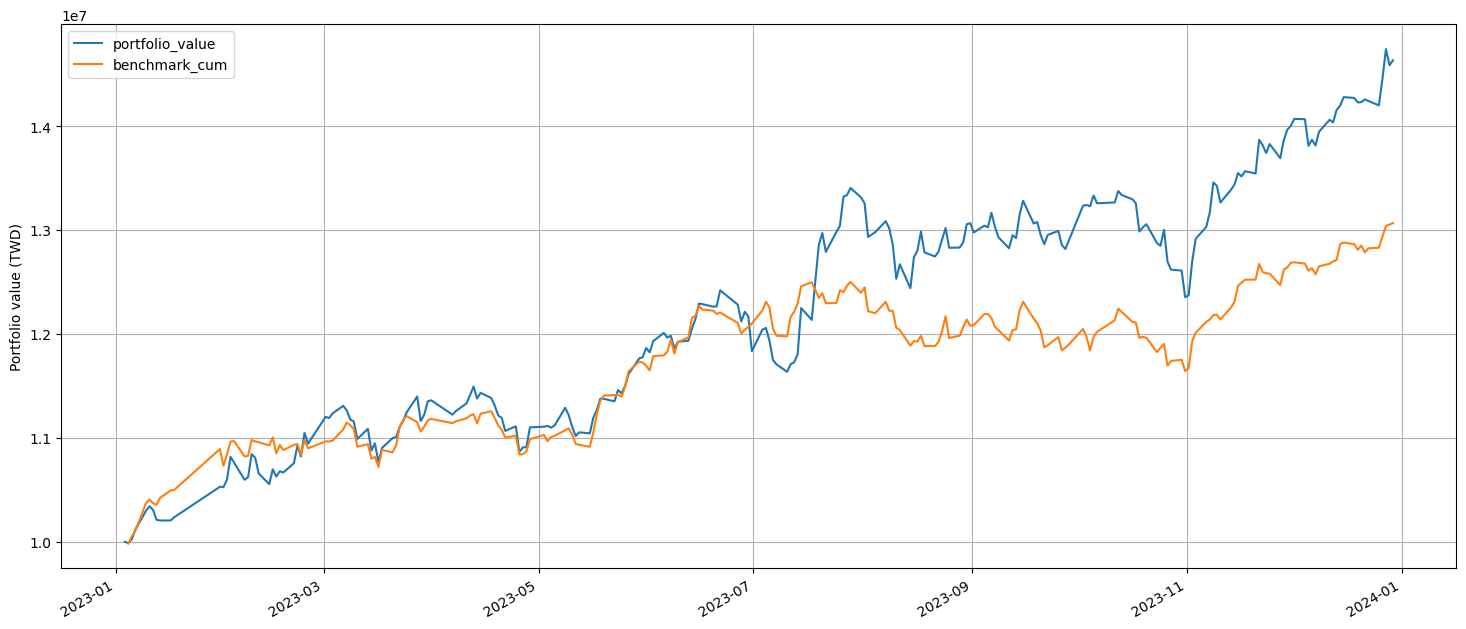

,period_open,period_close,long_value,orders,capital_used,short_value,pnl,long_exposure,treasury_return,short_exposure,...,trading_days,period_label,treasury_period_return,max_drawdown,benchmark_period_return,excess_return,benchmark_volatility,algo_volatility,algorithm_period_return,benchmark_cum
2023-01-03 13:30:00+08:00,2023-01-03 09:01:00+08:00,2023-01-03 13:30:00+08:00,0.00,"[{'id': '34629a64ba63497492bba471d491478a', 'd...",0.000000e+00,0.0,0.000000,0.00,0.0,0.0,...,1,2023-01,0.0,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN
2023-01-04 13:30:00+08:00,2023-01-04 09:01:00+08:00,2023-01-04 13:30:00+08:00,8688309.90,"[{'id': '34629a64ba63497492bba471d491478a', 'd...",-8.700771e+06,0.0,-12461.197328,8688309.90,0.0,0.0,...,2,2023-01,0.0,-0.001246,-0.001741,0.000495,NaN,0.013988,-0.001246,9.982590e+06
2023-01-05 13:30:00+08:00,2023-01-05 09:01:00+08:00,2023-01-05 13:30:00+08:00,9028559.00,"[{'id': '98d28c236e32470f952a0b73811d7659', 'd...",-3.022119e+05,0.0,38037.249738,9028559.00,0.0,0.0,...,3,2023-01,0.0,-0.001246,0.005424,-0.002867,0.100115,0.041803,0.002558,1.005424e+07
2023-01-06 13:30:00+08:00,2023-01-06 09:01:00+08:00,2023-01-06 13:30:00+08:00,9132910.70,"[{'id': '8c50aaad256f48a8af51ab8e2e1053c0', 'd...",-1.104569e+04,0.0,93306.010937,9132910.70,0.0,0.0,...,4,2023-01,0.0,-0.001246,0.010506,0.001382,0.073959,0.075274,0.011888,1.010506e+07
2023-01-09 13:30:00+08:00,2023-01-09 09:01:00+08:00,2023-01-09 13:30:00+08:00,9338889.75,"[{'id': '8c50aaad256f48a8af51ab8e2e1053c0', 'd...",-2.707319e+04,0.0,178905.860469,9338889.75,0.0,0.0,...,5,2023-01,0.0,-0.001246,0.037143,-0.007364,0.191248,0.123126,0.029779,1.037143e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,13181892.00,[],0.000000e+00,0.0,-42767.700000,13181892.00,0.0,0.0,...,235,2023-12,0.0,-0.078413,0.283076,0.137032,0.126110,0.172067,0.420107,1.283076e+07
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,13435998.80,[],0.000000e+00,0.0,254106.800000,13435998.80,0.0,0.0,...,236,2023-12,0.0,-0.078413,0.293786,0.151732,0.126064,0.172529,0.445518,1.293786e+07
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,13724012.90,[],0.000000e+00,0.0,288014.100000,13724012.90,0.0,0.0,...,237,2023-12,0.0,-0.078413,0.303973,0.170346,0.125989,0.173194,0.474319,1.303973e+07
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,13567498.50,[],0.000000e+00,0.0,-156514.400000,13567498.50,0.0,0.0,...,238,2023-12,0.0,-0.078413,0.305349,0.153319,0.125721,0.173292,0.458668,1.305349e+07


In [30]:
from zipline import run_algorithm
from zipline.utils.run_algo import get_transaction_detail

start_date = pd.Timestamp(start, tz = 'utc')
end_date = pd.Timestamp(end, tz = 'utc')  # 轉換成時間序列格式

results = run_algorithm(
    start = start_date,
    end = end_date,
    initialize = initialize,
    handle_data = handle_data,
    analyze = analyze,
    bundle = 'tquant',
    capital_base = capital_base,
)

results  # 回測結果

In [31]:
results.columns

Index(['period_open', 'period_close', 'long_value', 'orders', 'capital_used',
       'short_value', 'pnl', 'long_exposure', 'treasury_return',
       'short_exposure', 'benchmark_return', 'returns', 'positions',
       'longs_count', 'starting_value', 'ending_exposure', 'ending_value',
       'starting_cash', 'gross_leverage', 'starting_exposure', 'ending_cash',
       'portfolio_value', 'net_leverage', 'shorts_count', 'transactions',
       'alpha', 'beta', 'sharpe', 'sortino', 'max_leverage', 'trading_days',
       'period_label', 'treasury_period_return', 'max_drawdown',
       'benchmark_period_return', 'excess_return', 'benchmark_volatility',
       'algo_volatility', 'algorithm_period_return', 'benchmark_cum'],
      dtype='object')

<Axes: >

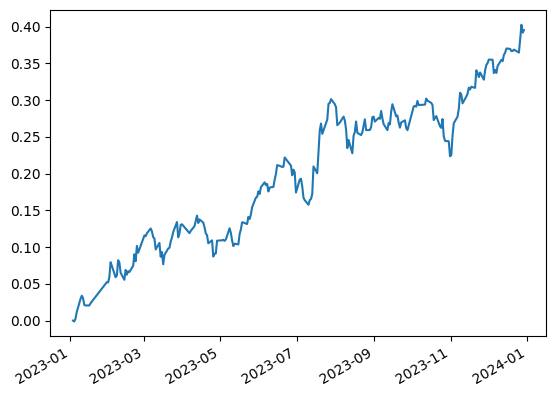

In [32]:
results.returns.cumsum().plot()  # 繪製累積回報圖

## Pyfolio

Pyfolio 與 zipline 的回測結果兼容，讓我們輕鬆用幾行程式碼，就能產出我們需要的投資風險及績效圖表。

p.s. 詳細 Pyfolio 使用方法可參考： TQuant Lab github：[Pyfolio](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Pyfolio.ipynb)

In [53]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import pyfolio

returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)  # 從 results 資料表中取出 returns, positions & transactions
benchmark_rets = results.benchmark_return  # 取出 benchmark 的報酬率

<Axes: title={'center': 'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

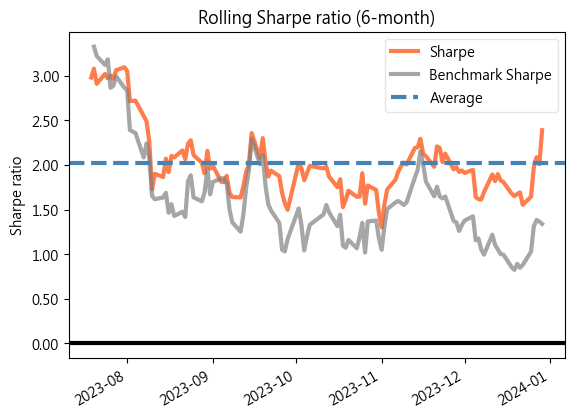

In [54]:
# 繪製夏普比率圖

from pyfolio.plotting import plot_rolling_sharpe

plot_rolling_sharpe(returns,
                    factor_returns=benchmark_rets)

Start date,2023-01-03
End date,2023-12-29
Total months,11
,Backtest
Annual return,49.422%
Cumulative returns,46.358%
Annual volatility,17.294%
Sharpe ratio,2.41
Calmar ratio,6.30
Stability,0.92
Max drawdown,-7.841%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.84,2023-07-28,2023-10-31,2023-11-08,70
1,6.32,2023-06-21,2023-07-10,2023-07-18,18
2,5.46,2023-04-12,2023-04-25,2023-05-25,31
3,4.81,2023-03-06,2023-03-16,2023-03-27,16
4,2.66,2023-02-08,2023-02-13,2023-02-21,10


Stress Events,mean,min,max
New Normal,0.17%,-2.74%,3.76%


Top 10 long positions of all time,max
sid,
2059,22.60%
3037,14.57%
3557,14.44%
2303,13.10%
6409,12.72%
2454,12.26%
3413,11.83%
1476,11.21%
2603,10.92%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2059,22.60%
3037,14.57%
3557,14.44%
2303,13.10%
6409,12.72%
2454,12.26%
3413,11.83%
1476,11.21%
2603,10.92%


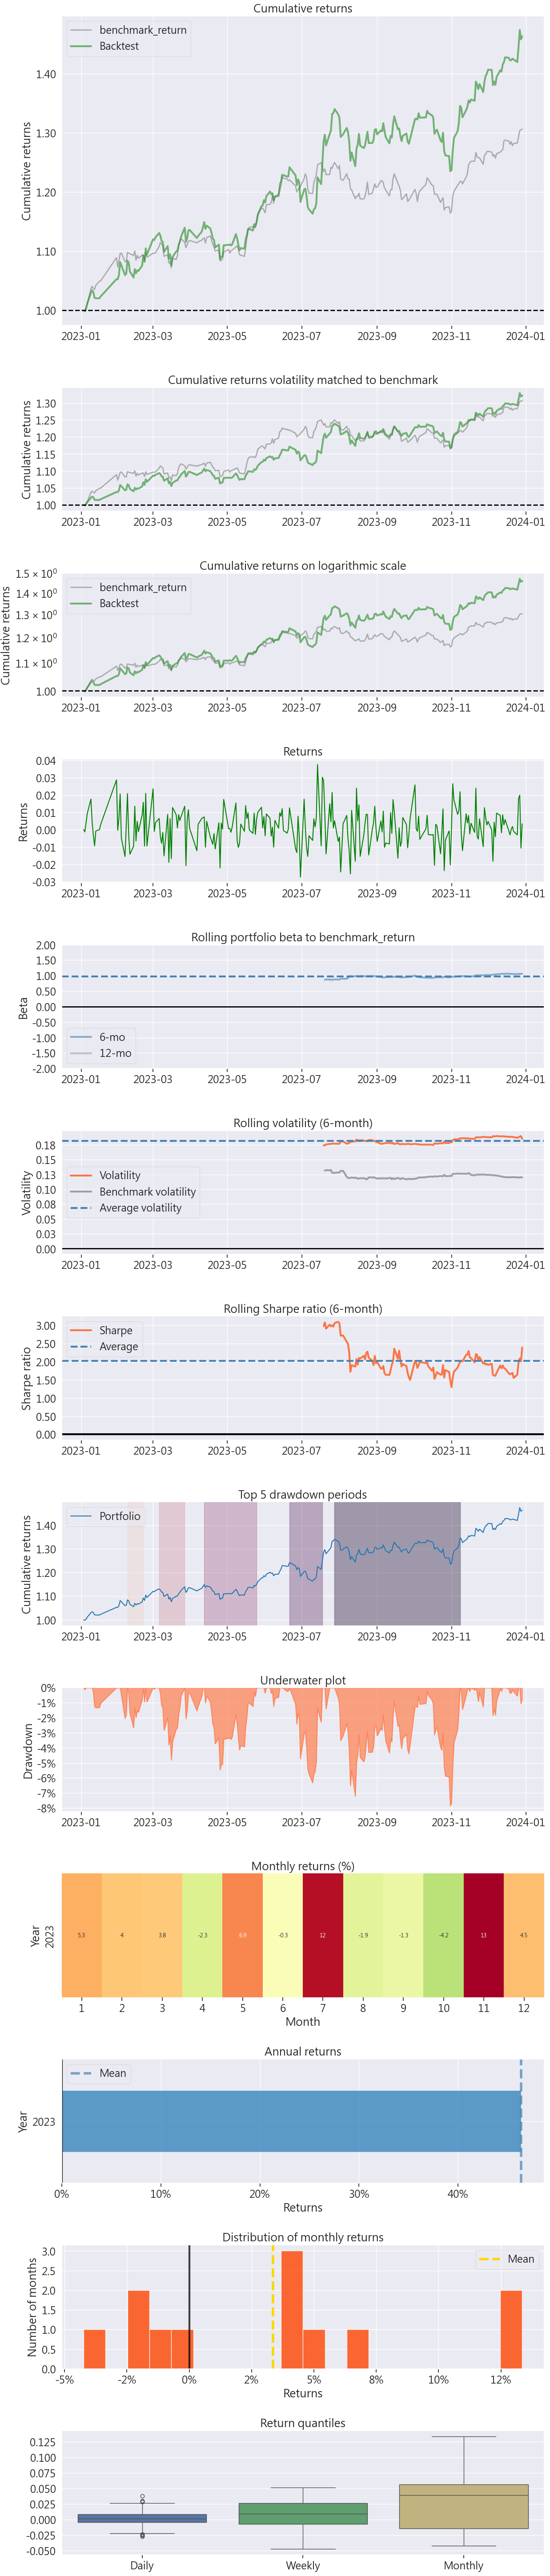

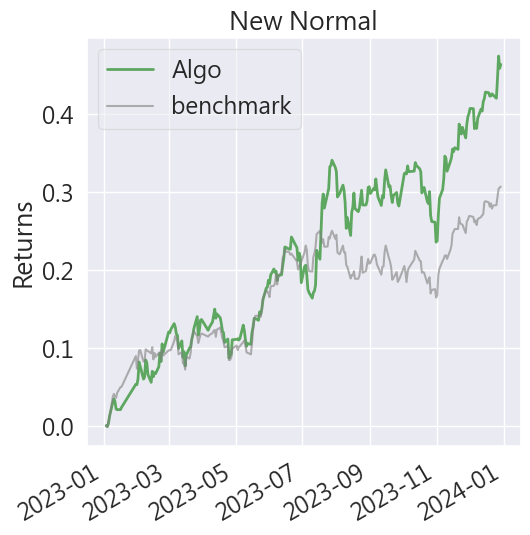

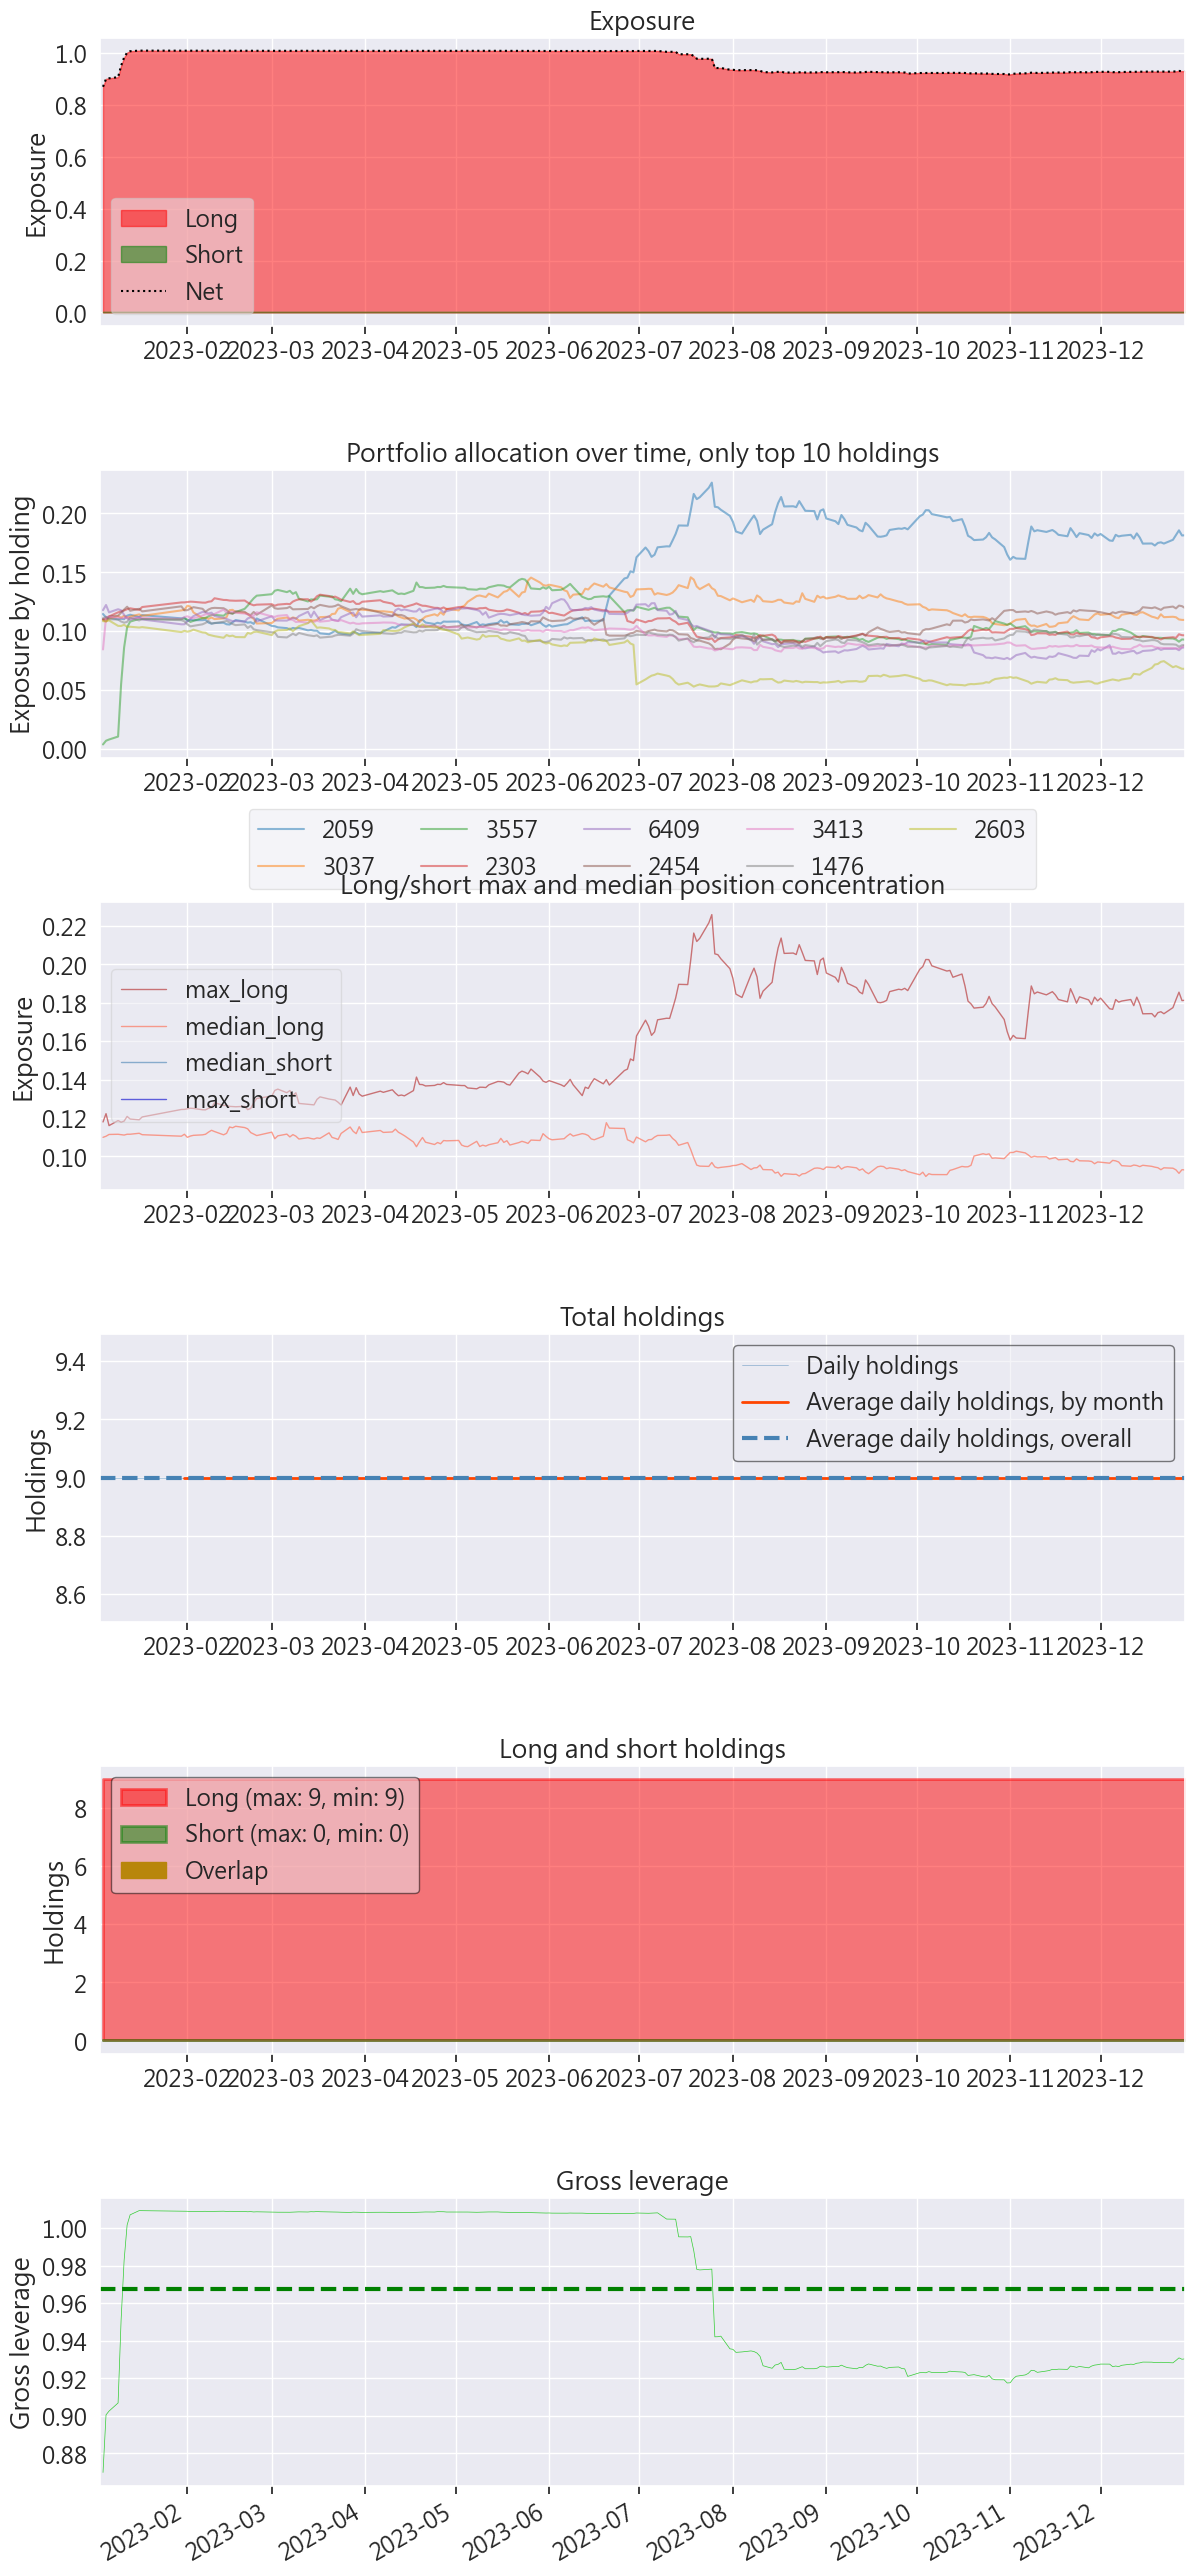

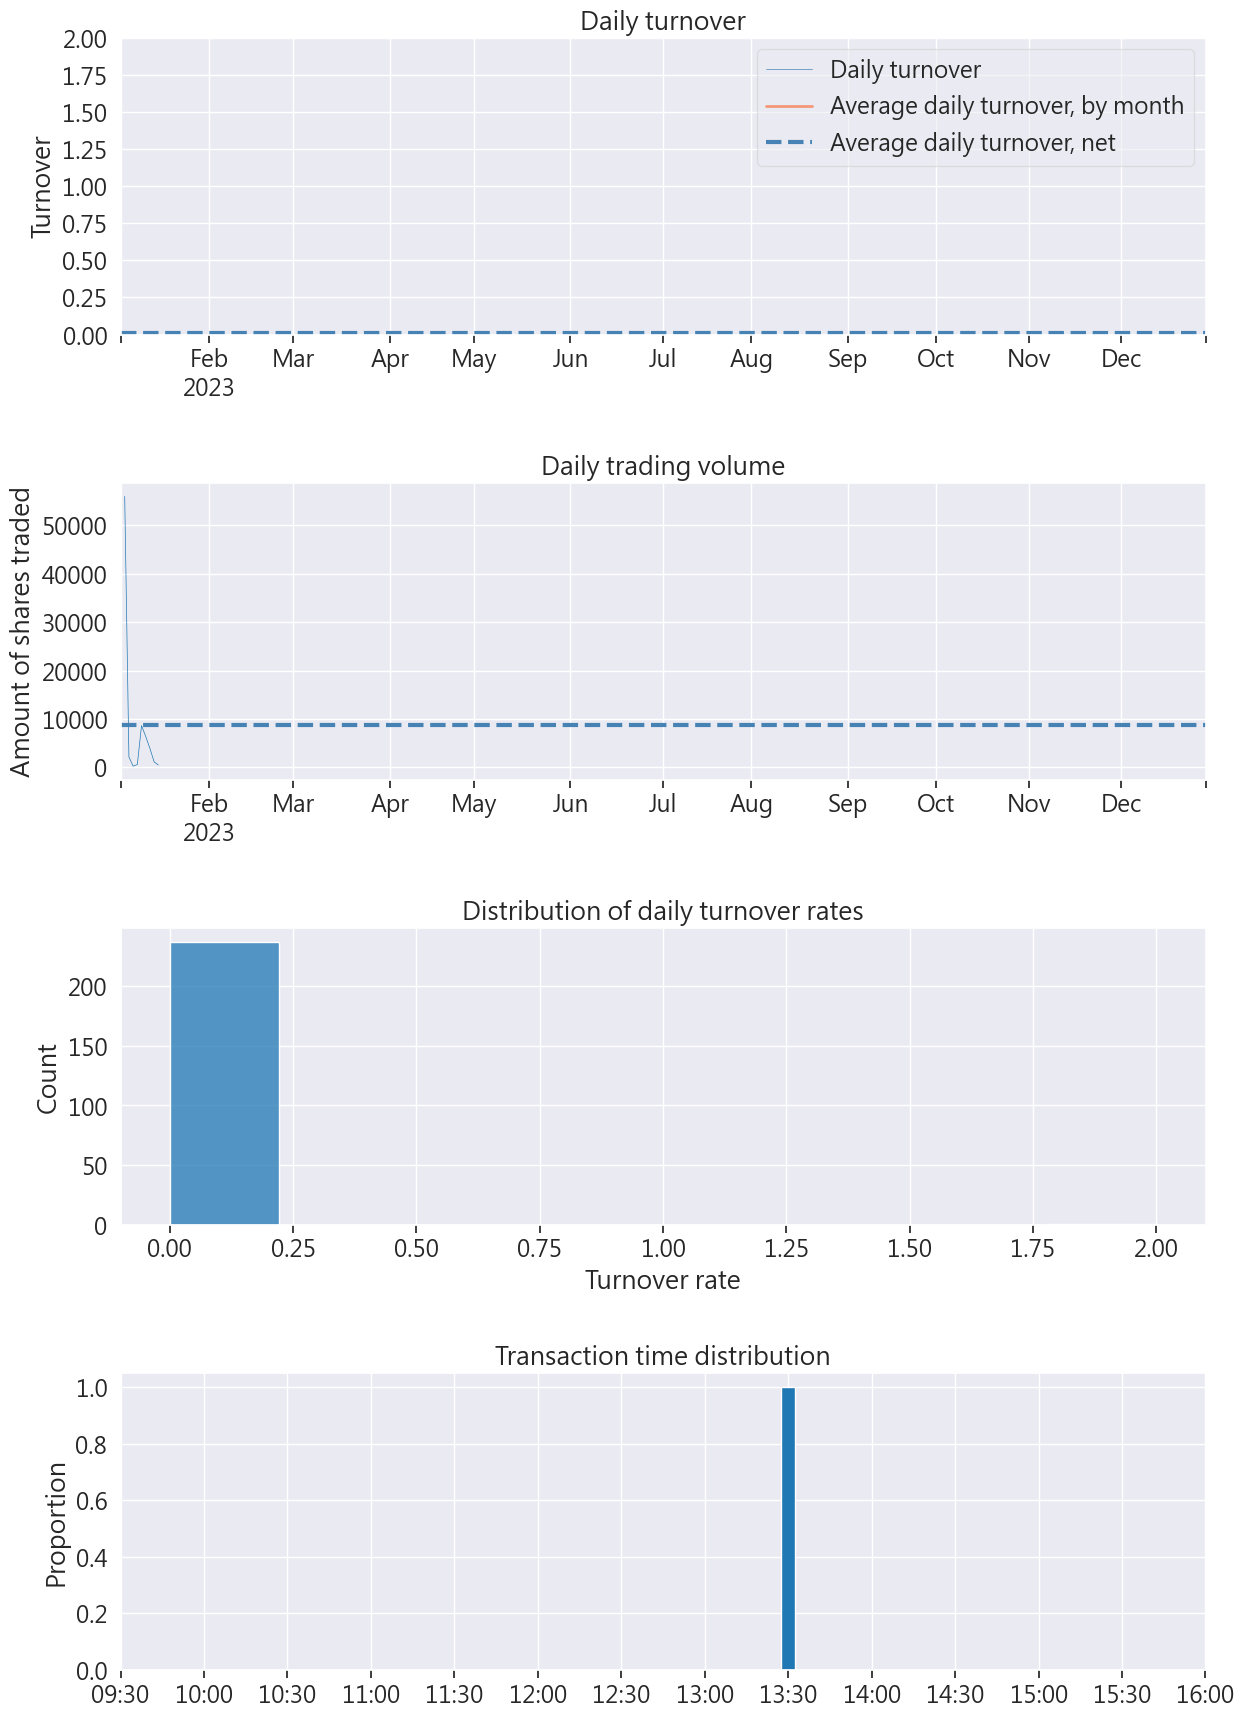

In [55]:
# 繪製 Pyfolio 中提供的所有圖表
pyfolio.tears.create_full_tear_sheet(returns=returns,
                                     positions=positions,
                                     transactions=transactions,
                                     benchmark_rets=benchmark_rets
                                    )

## 額外補充：查看 positions, transactions & orders 資料表

In [33]:
# 取出 results 中的 positions, transactions & orders 資料表
positions, transactions, orders = get_transaction_detail(results)   

In [ ]:
positions

In [ ]:
transactions

In [ ]:
orders

In [ ]:
orders[orders['symbol'] == '3557']

In [ ]:
orders.loc['2023-01-03']